In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#display the row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1197bb390>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
lastdate = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
yearago = dt.date(2017,8,23) - dt.timedelta(days=365)
yearago

# Perform a query to retrieve the data and precipitation scores & sort the date
results = session.query(Measurement.date, Measurement.prcp).\
    order_by(Measurement.date.desc()).all()
last12m = [result for result in results if result[0] >= str(yearago)]

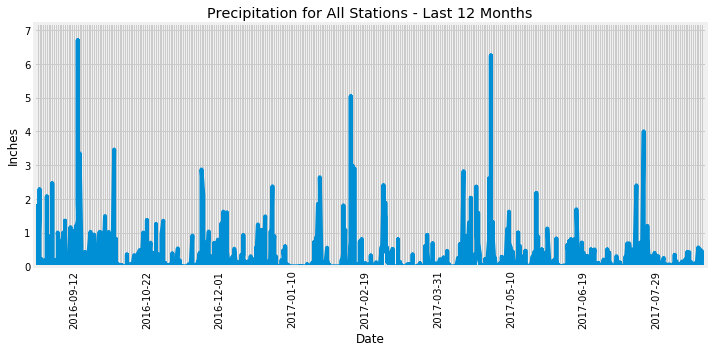

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcpDF = pd.DataFrame(last12m, columns=['Date','Precipitation'])
prcpDF = prcpDF.dropna(how='any')
prcpDF['Precipitation'] = pd.to_numeric(prcpDF['Precipitation'])
prcpDF = prcpDF.sort_values("Date")


# Use Pandas Plotting with Matplotlib to plot the data
x = [x for x in prcpDF.Date]
y = [y for y in prcpDF.Precipitation]


fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x,y)
plt.setp(ax.get_xticklabels(), rotation=90)
n = 20
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i%n !=0]

plt.setp(ax.get_xticklabels()[::2], visible=False)


plt.xlim(-2,367)
plt.ylim(0,max(y)+0.5)
plt.ylabel('Inches')
plt.xlabel('Date')
plt.title('Precipitation for All Stations - Last 12 Months')
plt.tight_layout()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpDF.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(Station.name)).all()
stations

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_result = session.query(Measurement.station, Measurement.id).all()
stationDF = pd.DataFrame(station_result)
stationDFGrouped = stationDF.groupby(['station']).count()

# List the stations and the counts in descending order.
stationMostActive = pd.DataFrame(stationDFGrouped).sort_values("id", ascending=False)
stationMostActive

,id
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [16]:
mostActive = stationMostActive.reset_index(drop=False)['station'][0]
mostActive

'USC00519281'

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
USC00519281 = session.query(Measurement.tobs, Measurement.station).\
    filter(Measurement.station == mostActive).all()
USC00519281DF = pd.DataFrame(USC00519281, columns=('Temperature', 'Station'))
USC00519281DF = USC00519281DF.set_index("Station")

#lowest temperature 
lowest_temp = USC00519281DF['Temperature'].min()
print(f"The lowest temperature is {lowest_temp}.")

#highest_temperature
highest_temp = USC00519281DF['Temperature'].max()
print(f"The highest temperature is {highest_temp}.")

#average temperature 
avg_temp = round(USC00519281DF['Temperature'].mean(),2)
print(f"The average temperature is {avg_temp}.")

The lowest temperature is 54.0.
The highest temperature is 85.0.
The average temperature is 71.66.


In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
mostTemp = session.query(Measurement.station, Measurement.tobs).all()
stationMostTemp = pd.DataFrame(mostTemp)
stationMostTempGrouped = stationMostTemp.groupby("station").count().sort_values("tobs", ascending=False)
stationMostTempGrouped = stationMostTempGrouped[:1]

lastdate = session.query(Measurement.date).\
    filter(Measurement.station == mostActive).\
    order_by(Measurement.date.desc()).first()

yearago = dt.date(2017,8,18) - dt.timedelta(days=365)
yearago

USC00519281Query = session.query(Measurement.station, Measurement.tobs, Measurement.date).\
    filter(Measurement.station == mostActive).\
    filter(Measurement.date >= str(yearago)).all()
USC00519281QueryDF = pd.DataFrame(USC00519281Query)

#use describe to get min # to use in bins 
USC00519281QueryDF['tobs'].describe()

bins = [59]
r = 0 
for i in bins:
    if r < 84:
        r = i+2
        bins.append(r)
bins 

[59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85]

Text(0.5, 1.0, 'Temp Histogram of Station USC00519281')

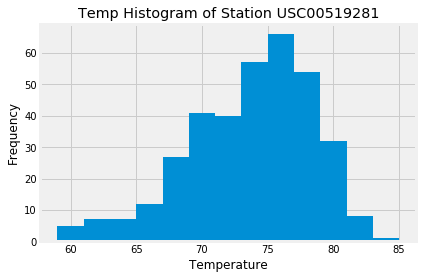

In [19]:
#create bins based on max and min 
groupNames = [str(x) for x in bins[:-1]]
USC00519281QueryDF['Temp Bins'] = pd.cut(USC00519281QueryDF['tobs'],bins,labels=groupNames,include_lowest=True)
USC00519281QueryDFGrouped = USC00519281QueryDF.groupby("Temp Bins").count()['station']
USC00519281QueryDFGrouped = pd.DataFrame(USC00519281QueryDFGrouped).sort_values('station',ascending=False)
USC00519281QueryDFGrouped = USC00519281QueryDFGrouped.reset_index()

# Use Pandas Plotting with Matplotlib to plot the data as a histogram
x = [x for x in USC00519281QueryDF['tobs']]

ax = plt.hist(x, bins=bins)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temp Histogram of Station {mostActive}')

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
